<a href="https://colab.research.google.com/github/reshmaessudhakaran/AnomalyDetection_python/blob/main/SeasonalityAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure all necessary imports are included
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
class DataConsolidation:
    def __init__(self, frequency):
        self.frequency = frequency

    def consolidate(self, data):
        try:
            data['order_time'] = pd.to_datetime(data['order_time'], format='%d-%m-%Y %H:%M')
            if self.frequency == 'H':
                data['Date'] = data['order_time'].dt.floor('H')
            elif self.frequency == 'D':
                data['Date'] = data['order_time'].dt.floor('D')
            elif self.frequency == 'W':
                data['Date'] = data['order_time'].dt.to_period('W-SUN').apply(lambda r: r.start_time)
            else:
                raise ValueError(f"Unsupported frequency: {self.frequency}")

            data = data.groupby('Date')['total_price'].sum().reset_index()
        except Exception as e:
            print(f"Error consolidating data: {e}")
            return None
        return data

In [4]:
def get_current_week():
    return datetime.now().isocalendar()[1]

def get_last_retrained_week(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            return int(file.readline().strip())
    return None

def update_last_retrained_week(file_path, week):
    current_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(file_path, 'w') as file:
        file.write(f"{week}\nRetrained on: {current_date}")


In [5]:
def read_and_preprocess_data(filepath, frequency):
    data = pd.read_csv(filepath)
    consolidator = DataConsolidation(frequency)
    consolidated_data = consolidator.consolidate(data)
    return consolidated_data

def decompose_series(data, frequency, model):
    try:
        result = seasonal_decompose(data['total_price'], model=model, period=frequency)
        trend = result.trend
        seasonal = result.seasonal
        resid = result.resid

        trend = trend.fillna(method='ffill').fillna(method='bfill')
        seasonal = seasonal.fillna(method='ffill').fillna(method='bfill')
        resid = resid.fillna(method='ffill').fillna(method='bfill')
        return trend, seasonal, resid
    except Exception as e:
        print(f"Error in seasonal decomposition: {e}")
        return None, None, None


def plot_decomposition(trend, seasonal, residual, original_data, title_prefix=''):
    try:
        plt.figure(figsize=(12, 8))
        plt.subplot(411)
        plt.plot(original_data, label='Original')
        plt.legend(loc='upper left')
        plt.title(f'{title_prefix} Original Data')

        plt.subplot(412)
        plt.plot(trend, label='Trend')
        plt.legend(loc='upper left')
        plt.title(f'{title_prefix} Trend')

        plt.subplot(413)
        plt.plot(seasonal, label='Seasonal')
        plt.legend(loc='upper left')
        plt.title(f'{title_prefix} Seasonal')

        plt.subplot(414)
        plt.plot(residual, label='Residual')
        plt.legend(loc='upper left')
        plt.title(f'{title_prefix} Residual')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in plotting decomposition: {e}")


def scale_data(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = data[['total_price']].values  # Scale only total_price column
    scaled_data = scaler.fit_transform(dataset)
    return scaled_data, scaler, dataset

def create_train_test_datasets(total_price, decomposition_data, scaler):
    combined_data = np.hstack((total_price, decomposition_data))
    scaled_combined_data = scaler.transform(combined_data)
    x_data = np.expand_dims(scaled_combined_data, axis=-1)
    print("x_data shape:", x_data.shape)
    return x_data


def build_and_train_autoencoder(x_train, autoencoder_model_path, callbacks=[]):
    input_layer_ae = Input(shape=(x_train.shape[1], x_train.shape[2]))
    encoded_ae = LSTM(32, activation='relu', return_sequences=True)(input_layer_ae)
    encoded_ae = LSTM(16, activation='relu', return_sequences=False)(encoded_ae)
    decoded_ae = Dense(x_train.shape[1], activation='linear')(encoded_ae)
    autoencoder = Model(input_layer_ae, decoded_ae)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
    callbacks = [early_stopping] + callbacks

    autoencoder.fit(x_train, x_train, epochs=2, batch_size=32, callbacks=callbacks, verbose=1)
    autoencoder.save(autoencoder_model_path.replace('.h5', '.keras'))  # Save as .keras file
    return autoencoder

def calculate_reconstruction_errors(autoencoder, test_data):
    reconstructed_test_data = autoencoder.predict(test_data)
    reconstruction_errors = np.mean(np.abs(reconstructed_test_data - test_data), axis=(1, 2))
    return reconstruction_errors

def calculate_dynamic_thresholds(window, seasonal_component, current_index):

    # Calculate mean and standard deviation of the window
    mean = np.mean(window)
    std_dev = np.std(window)

    # Determine the seasonality adjustment based on the current index
    if current_index < len(seasonal_component):
        seasonal_adjustment = seasonal_component[current_index]
    else:
        seasonal_adjustment = 0

    # Adjust thresholds based on the seasonal component
    lower_threshold = mean - 3 * std_dev + seasonal_adjustment
    upper_threshold = mean + 3 * std_dev + seasonal_adjustment

    return lower_threshold, upper_threshold


def detect_anomalies_with_dynamic_thresholds(data_points, reconstruction_errors, seasonal_component, window_size):
    anomalies = []

    for i in range(window_size, len(data_points)):
        window = data_points[i-window_size:i]

        # Calculate dynamic thresholds
        lower_threshold, upper_threshold = calculate_dynamic_thresholds(window, seasonal_component, i)

        # Detect anomaly
        if data_points[i] < lower_threshold or data_points[i] > upper_threshold:
            anomalies.append((i, data_points[i], reconstruction_errors[i]))

    return anomalies


def compare_decomposition_models(data, frequency):
    additive_trend, additive_seasonal, additive_residual = decompose_series(data, frequency, model='additive')
    multiplicative_trend, multiplicative_seasonal, multiplicative_residual = decompose_series(data, frequency, model='multiplicative')

    plot_decomposition(additive_trend, additive_seasonal, additive_residual, data['total_price'], title_prefix='Additive')
    plot_decomposition(multiplicative_trend, multiplicative_seasonal, multiplicative_residual, data['total_price'], title_prefix='Multiplicative')


In [6]:
def main(train_filepath, test_filepath, autoencoder_model_path, output_filepath, week_file_path, frequency):
    current_week = get_current_week()
    last_retrained_week = get_last_retrained_week(week_file_path)

    retrain = False
    if last_retrained_week is None or current_week != last_retrained_week:
        retrain = True
        update_last_retrained_week(week_file_path, current_week)

    train_data = read_and_preprocess_data(train_filepath, frequency)
    test_data = read_and_preprocess_data(test_filepath, frequency)

    print("Train Data:")
    print(train_data.head())
    print("Test Data:")
    print(test_data.head())

    # Ensure 'Date' column is in datetime format
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    freq_value = 53 if frequency == 'W' else 365 if frequency == 'D' else 24

    trend, seasonal, residual = decompose_series(train_data, freq_value, model='multiplicative')

    if trend is not None and seasonal is not None and residual is not None:
        plot_decomposition(trend, seasonal, residual, train_data['total_price'])

        train_data['trend'] = trend
        train_data['seasonal'] = seasonal
        train_data['residual'] = residual
        test_data['trend'] = trend[:len(test_data)]
        test_data['seasonal'] = seasonal[:len(test_data)]
        test_data['residual'] = residual[:len(test_data)]
    else:
        print("Error in seasonal decomposition, check the data or frequency value.")
        return

    train_total_price = train_data[['total_price']].values
    test_total_price = test_data[['total_price']].values

    scaler = MinMaxScaler()
    scaled_train_total_price = scaler.fit_transform(train_total_price)
    scaled_test_total_price = scaler.transform(test_total_price)

    x_train = np.expand_dims(scaled_train_total_price, axis=-1)
    x_test = np.expand_dims(scaled_test_total_price, axis=-1)

    print("x_train shape:", x_train.shape)
    print("x_test shape:", x_test.shape)

    if retrain:
        autoencoder = build_and_train_autoencoder(x_train, autoencoder_model_path)
    else:
        try:
            autoencoder = load_model(autoencoder_model_path.replace('.h5', '.keras'))
        except OSError as e:
            print(f"Error loading model: {e}")
            print("Retraining the autoencoder model.")
            autoencoder = build_and_train_autoencoder(x_train, autoencoder_model_path)

    reconstruction_errors = calculate_reconstruction_errors(autoencoder, x_test)

    print("Reconstruction Errors:")
    print(reconstruction_errors[:10])

    anomalies = detect_anomalies_with_dynamic_thresholds(
        list(test_total_price.flatten()), reconstruction_errors, list(test_data['seasonal']), window_size=24
    )

    print(f"Anomalies detected: {len(anomalies)}")

    results = pd.DataFrame({
        'Date': test_data['Date'],
        'Price': test_data['total_price'],
        'Reconstruction Error': reconstruction_errors,
        'Anomaly': ['TRUE' if i in [a[0] for a in anomalies] else 'FALSE' for i in range(len(test_data))]
    })

    results.to_csv(output_filepath, index=False)
    print("Results saved to:", output_filepath)
    print(results)


Train Data:
                 Date  total_price
0 2004-10-01 01:00:00        12379
1 2004-10-01 02:00:00        11935
2 2004-10-01 03:00:00        11692
3 2004-10-01 04:00:00        11597
4 2004-10-01 05:00:00        11681
Test Data:
                 Date  total_price
0 2015-10-27 10:00:00        15147
1 2015-10-27 11:00:00        14796
2 2015-10-27 12:00:00        14718
3 2015-10-27 13:00:00        14689
4 2015-10-27 14:00:00        14609


<ipython-input-5-d52ba1a60207>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend = trend.fillna(method='ffill').fillna(method='bfill')
<ipython-input-5-d52ba1a60207>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seasonal = seasonal.fillna(method='ffill').fillna(method='bfill')
<ipython-input-5-d52ba1a60207>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resid = resid.fillna(method='ffill').fillna(method='bfill')


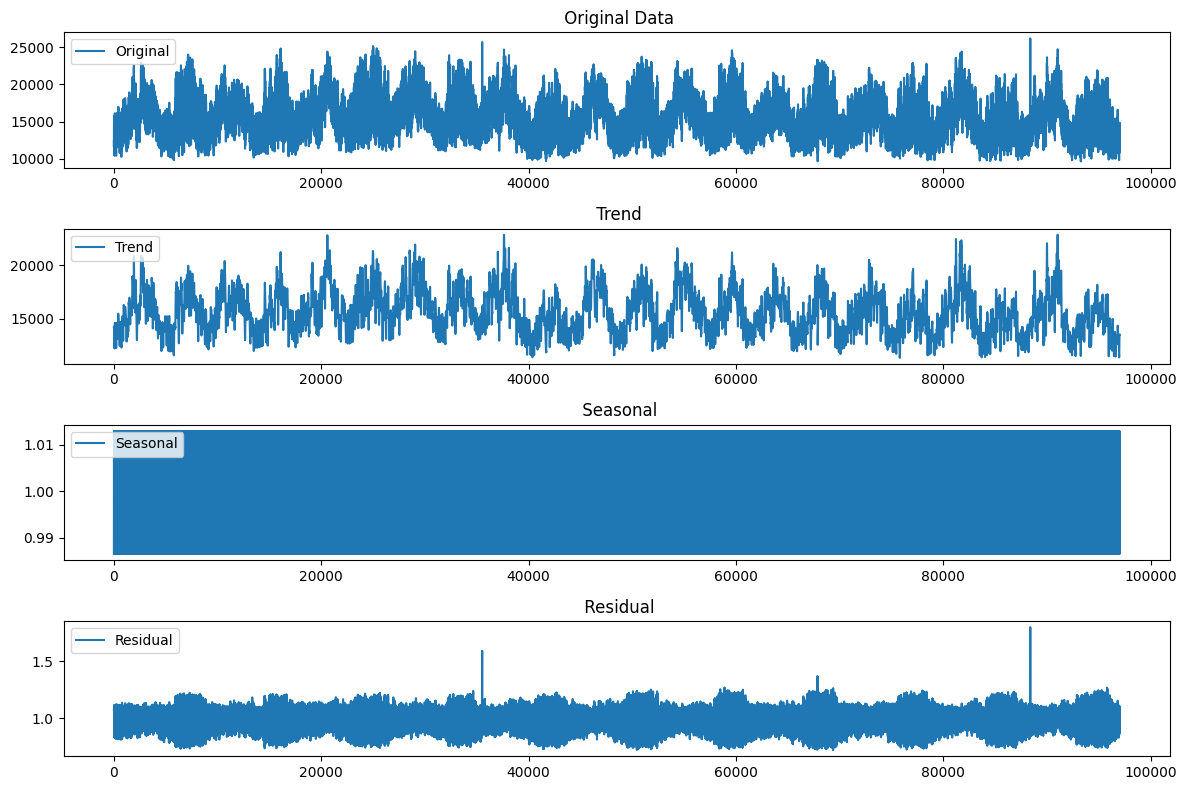

x_train shape: (97017, 1, 1)
x_test shape: (24252, 1, 1)
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Reconstruction Errors:
[0.12195477 0.11808263 0.11751466 0.11733324 0.11691688 0.11650254
 0.11649495 0.11649604 0.11686202 0.12128912]
Anomalies detected: 147
Results saved to: anomalies_on_seasonality.csv
                     Date  Price  Reconstruction Error Anomaly
0     2015-10-27 10:00:00  15147              0.121955   FALSE
1     2015-10-27 11:00:00  14796              0.118083   FALSE
2     2015-10-27 12:00:00  14718              0.117515   FALSE
3     2015-10-27 13:00:00  14689              0.117333   FALSE
4     2015-10-27 14:00:00  14609              0.116917   FALSE
...                   ...    ...                   ...     ...
24247 2018-08-02 20:00:00  17673              0.201245   FALSE
24248 2018-08-02 21:00:00  17303              0.185255   FALSE
24249 2018-08-02 22:00:00  17001              0.173100   FALSE
24250 2018-08-02 23:00:00  15964              0.138699   FALSE
24

In [8]:


train_filepath = '/content/drive/MyDrive/DatasetXTG/AEP_train_data.csv'
test_filepath = '/content/drive/MyDrive/DatasetXTG/AEP_test_data.csv'
autoencoder_model_path = '/content/drive/My Drive/autoencoder_model.h5'
output_filepath = 'anomalies_on_seasonality.csv'
week_file_path = 'last_retrained_week.txt'
frequency = 'H'  # Adjust this based on your data frequency ('H' for hourly, 'D' for daily, 'W' for weekly)

main(train_filepath, test_filepath, autoencoder_model_path, output_filepath, week_file_path, frequency)